# MACD Calculator

[*********************100%%**********************]  1 of 1 completed


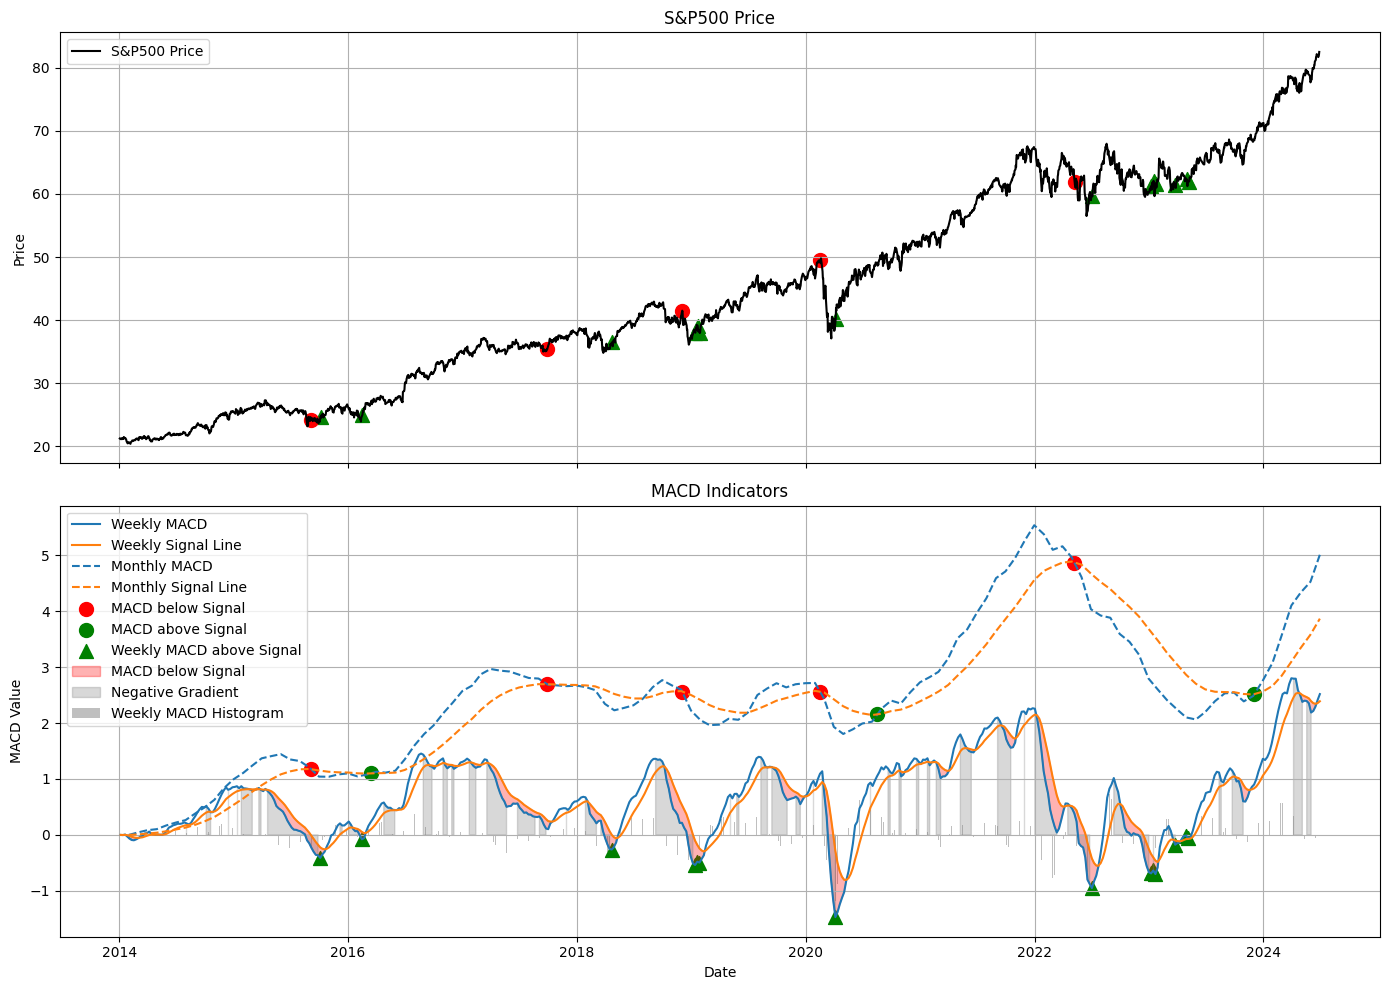

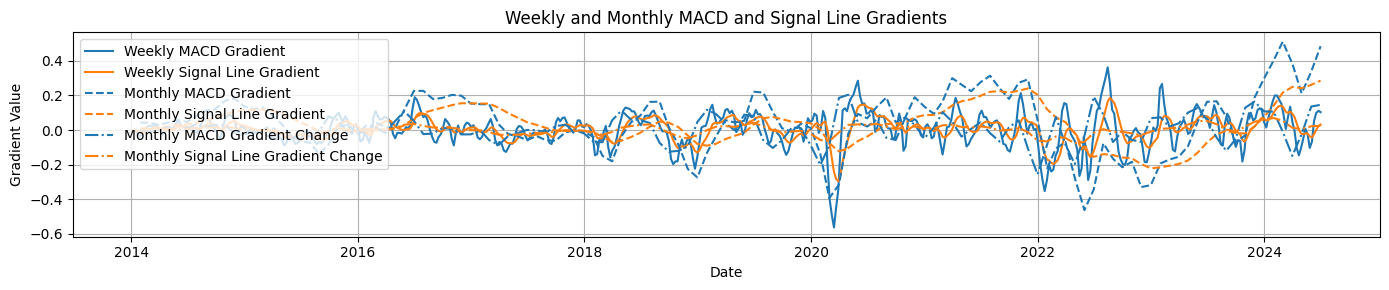

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import numpy as np

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    """
    Calculate the MACD and Signal Line indicators
    """
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df

def find_exact_crossover_points(df, threshold=0.01):
    """
    Find the exact crossover points where MACD crosses the Signal Line using interpolation
    """
    downcrosses = []
    upcrosses = []
    for i in range(1, len(df)):
        macd_prev = df['MACD'].iloc[i-1]
        signal_prev = df['Signal_Line'].iloc[i-1]
        macd_current = df['MACD'].iloc[i]
        signal_current = df['Signal_Line'].iloc[i]
        
        # Downcrosses
        if macd_prev > signal_prev and macd_current < signal_current:
            if abs(macd_prev - signal_prev) > threshold:
                macd_diff = macd_current - macd_prev
                signal_diff = signal_current - signal_prev
                crossover_time = df.index[i-1] + (df.index[i] - df.index[i-1]) * (macd_prev - signal_prev) / (signal_diff - macd_diff)
                crossover_time = pd.Timestamp(crossover_time).round('D')
                crossover_value = macd_prev + (macd_current - macd_prev) * (crossover_time - df.index[i-1]).total_seconds() / (df.index[i] - df.index[i-1]).total_seconds()
                downcrosses.append((crossover_time, crossover_value))
        
        # Upcrosses
        if macd_prev < signal_prev and macd_current > signal_current:
            if abs(macd_prev - signal_prev) > threshold:
                macd_diff = macd_current - macd_prev
                signal_diff = signal_current - signal_prev
                crossover_time = df.index[i-1] + (df.index[i] - df.index[i-1]) * (macd_prev - signal_prev) / (signal_diff - macd_diff)
                crossover_time = pd.Timestamp(crossover_time).round('D')
                crossover_value = macd_prev + (macd_current - macd_prev) * (crossover_time - df.index[i-1]).total_seconds() / (df.index[i] - df.index[i-1]).total_seconds()
                upcrosses.append((crossover_time, crossover_value))
                
    return downcrosses, upcrosses

def calculate_gradients(df):
    """
    Calculate the gradient (slope) and the rate of change of the gradient of the MACD and Signal Line
    """
    df['MACD_Gradient'] = np.gradient(df['MACD'])
    df['Signal_Line_Gradient'] = np.gradient(df['Signal_Line'])
    df['MACD_Gradient_Change'] = np.gradient(df['MACD_Gradient'])
    df['Signal_Line_Gradient_Change'] = np.gradient(df['Signal_Line_Gradient'])
    return df

def find_nearest_index(df, target_date):
    """
    Find the nearest index to a given date
    """
    return df.index.get_loc(df.index[df.index.get_indexer([target_date], method='nearest')[0]])

def plot_price_and_macd(df_price, df_weekly, df_monthly, downcrosses, upcrosses, weekly_upcrosses, confirmed_weekly_upcrosses):
    """
    Plot the S&P500 price along with weekly and monthly MACD indicators
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    ax1.plot(df_price.index, df_price['Close'], label='S&P500 Price', color='black')
    ax1.set_title('S&P500 Price')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # Mark the confirmed weekly upcrosses on the stock price graph
    for crossover in confirmed_weekly_upcrosses:
        nearest_index = find_nearest_index(df_price, crossover[0])
        ax1.scatter(df_price.index[nearest_index], df_price['Close'].iloc[nearest_index], color='green', marker='^', s=100)
    
    # Mark the exact crossover points where the monthly MACD falls below the monthly Signal line with red circles
    for crossover in downcrosses:
        nearest_index = find_nearest_index(df_price, crossover[0])
        ax1.scatter(df_price.index[nearest_index], df_price['Close'].iloc[nearest_index], color='red', marker='o', s=100)
    
    ax2.plot(df_weekly.index, df_weekly['MACD'], label='Weekly MACD', color='tab:blue', linewidth=1.5)
    ax2.plot(df_weekly.index, df_weekly['Signal_Line'], label='Weekly Signal Line', color='tab:orange', linestyle='-', linewidth=1.5)
    ax2.bar(df_weekly.index, df_weekly['MACD'] - df_weekly['Signal_Line'], label='Weekly MACD Histogram', color='grey', alpha=0.5)
    
    ax2.plot(df_monthly.index, df_monthly['MACD'], label='Monthly MACD', color='tab:blue', linestyle='--', linewidth=1.5)
    ax2.plot(df_monthly.index, df_monthly['Signal_Line'], label='Monthly Signal Line', color='tab:orange', linestyle='--', linewidth=1.5)
    
    # Mark the exact crossover points where the monthly MACD falls below the monthly Signal line
    downcross_dates = [date for date, value in downcrosses]
    downcross_values = [value for date, value in downcrosses]
    ax2.scatter(downcross_dates, downcross_values, color='red', marker='o', s=100, label='MACD below Signal')
    
    upcross_dates = [date for date, value in upcrosses]
    upcross_values = [value for date, value in upcrosses]
    ax2.scatter(upcross_dates, upcross_values, color='green', marker='o', s=100, label='MACD above Signal')
    
    # Mark the confirmed weekly upcrosses on the MACD graph
    weekly_upcross_dates = [date for date, value in confirmed_weekly_upcrosses]
    weekly_upcross_values = [value for date, value in confirmed_weekly_upcrosses]
    ax2.scatter(weekly_upcross_dates, weekly_upcross_values, color='green', marker='^', s=100, label='Weekly MACD above Signal')
    
    # Highlight regions where the weekly MACD is below the signal line
    ax2.fill_between(df_weekly.index, df_weekly['MACD'], df_weekly['Signal_Line'], 
                     where=(df_weekly['MACD'] < df_weekly['Signal_Line']), 
                     color='red', alpha=0.3, label='MACD below Signal')
    
    # Highlight regions where the weekly MACD has a negative gradient
    ax2.fill_between(df_weekly.index, df_weekly['MACD'], 
                     where=(df_weekly['MACD_Gradient'] < 0), 
                     color='grey', alpha=0.3, label='Negative Gradient')
    
    ax2.set_title('MACD Indicators')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD Value')
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_gradients(df_weekly, df_monthly):
    """
    Plot the gradients of the weekly and monthly MACD and Signal Line
    """
    fig, ax = plt.subplots(figsize=(14, 3))  # Adjusted height to 3
    
    ax.plot(df_weekly.index, df_weekly['MACD_Gradient'], label='Weekly MACD Gradient', color='tab:blue', linewidth=1.5)
    ax.plot(df_weekly.index, df_weekly['Signal_Line_Gradient'], label='Weekly Signal Line Gradient', color='tab:orange', linestyle='-', linewidth=1.5)
    
    ax.plot(df_monthly.index, df_monthly['MACD_Gradient'], label='Monthly MACD Gradient', color='tab:blue', linestyle='--', linewidth=1.5)
    ax.plot(df_monthly.index, df_monthly['Signal_Line_Gradient'], label='Monthly Signal Line Gradient', color='tab:orange', linestyle='--', linewidth=1.5)
    
    ax.plot(df_monthly.index, df_monthly['MACD_Gradient_Change'], label='Monthly MACD Gradient Change', color='tab:blue', linestyle='-.', linewidth=1.5)
    ax.plot(df_monthly.index, df_monthly['Signal_Line_Gradient_Change'], label='Monthly Signal Line Gradient Change', color='tab:orange', linestyle='-.', linewidth=1.5)
    
    ax.set_title('Weekly and Monthly MACD and Signal Line Gradients')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gradient Value')
    ax.legend(loc='upper left')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    ticker = 'VUSA.L'
    end_date = datetime.today().strftime('%Y-%m-%d')
    df = yf.download(ticker, start='2014-01-01', end=end_date)
    
    df_weekly = df.resample('W').last()
    df_monthly = df.resample('M').last()
    
    df_weekly = calculate_macd(df_weekly)
    df_monthly = calculate_macd(df_monthly)
    
    df_weekly = calculate_gradients(df_weekly)
    df_monthly = calculate_gradients(df_monthly)
    
    downcrosses, upcrosses = find_exact_crossover_points(df_monthly)
    
    # Use linear interpolation to estimate the gradient at the crossover points
    def interpolate_gradient(df, timestamp):
        if timestamp in df.index:
            return df.loc[timestamp, 'MACD_Gradient']
        else:
            before = df.index[df.index < timestamp][-1]
            after = df.index[df.index > timestamp][0]
            gradient_before = df.loc[before, 'MACD_Gradient']
            gradient_after = df.loc[after, 'MACD_Gradient']
            weight = (timestamp - before) / (after - before)
            return gradient_before * (1 - weight) + gradient_after * weight
    
    def interpolate_gradient_change(df, timestamp):
        if timestamp in df.index:
            return df.loc[timestamp, 'MACD_Gradient_Change']
        else:
            before = df.index[df.index < timestamp][-1]
            after = df.index[df.index > timestamp][0]
            gradient_change_before = df.loc[before, 'MACD_Gradient_Change']
            gradient_change_after = df.loc[after, 'MACD_Gradient_Change']
            weight = (timestamp - before) / (after - before)
            return gradient_change_before * (1 - weight) + gradient_change_after * weight
    
    # Define a gradient threshold
    gradient_threshold = -0.01
    
    # Filter downcrosses to only include those where the gradient of the monthly MACD is below the threshold
    downcrosses = [crossover for crossover in downcrosses if interpolate_gradient(df_monthly, crossover[0]) < gradient_threshold]
    
    # Filter upcrosses to only include those where the gradient of the monthly MACD is above the threshold
    upcrosses = [crossover for crossover in upcrosses if interpolate_gradient(df_monthly, crossover[0]) > abs(gradient_threshold)]
    
    # Find weekly upcrosses where the weekly MACD crosses above the signal line
    weekly_upcrosses = [(df_weekly.index[i], df_weekly['MACD'].iloc[i]) for i in range(1, len(df_weekly)) 
                        if df_weekly['MACD'].iloc[i-1] < df_weekly['Signal_Line'].iloc[i-1] and df_weekly['MACD'].iloc[i] > df_weekly['Signal_Line'].iloc[i]]

    def find_turning_points(df):
        turning_points = []
    
        for i in range(1, len(df) - 1):
            if (df['MACD'].iloc[i] > df['MACD'].iloc[i - 1] and df['MACD'].iloc[i] > df['MACD'].iloc[i + 1]) or \
               (df['MACD'].iloc[i] < df['MACD'].iloc[i - 1] and df['MACD'].iloc[i] < df['MACD'].iloc[i + 1]):
                turning_points.append((df.index[i], df['MACD'].iloc[i]))
    
        return turning_points

    turning_points = find_turning_points(df_weekly)

    
     # Find turning points for weekly MACD where MACD < 0 and other conditions are met
    confirmed_turning_points = []
    for turning_point in turning_points:
        if df_weekly.loc[turning_point[0], 'MACD'] < 0:
            for downcross in downcrosses:
                if downcross[0] < turning_point[0]:
                    # Check additional conditions here
                    # For example, if you want to ensure the monthly MACD gradient is positive or increasing:
                    nearest_monthly_index = find_nearest_index(df_monthly, turning_point[0])
                    if df_monthly['MACD_Gradient'].iloc[nearest_monthly_index] > 0 or df_monthly['MACD_Gradient_Change'].iloc[nearest_monthly_index] > 0:
                        confirmed_turning_points.append(turning_point)
                    break
    
    plot_price_and_macd(df, df_weekly, df_monthly, downcrosses, upcrosses, turning_points, confirmed_turning_points)
    plot_gradients(df_weekly, df_monthly)